In [89]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
prof_file_path = "Data/clean_prof_info.csv"
comment_file_path = "Data/clean_ratings.csv"


In [83]:
df_prof = pd.read_csv(prof_file_path)
df_comment = pd.read_csv(comment_file_path)

## Introduction

In this project, we analyze a dataset that contains information about University of Michigan professor ratings. More specifically, we want to build a machine learning model that studies the sentiment conveyed by the comments student gave to professors and use it to predict the sentiment of new comments. 

## Data

The source of the data is from [Rate My Professor](https://www.ratemyprofessors.com/search/teachers?query=*&sid=1258), a website where students can give anoymous and objective opinions about their professors. To gather out dataset, we took several steps.

### Step One
First, we want to know how many UofM professors are recorded on the website. In particular, we want to find a list of professor IDs. In order to do this, we find all professors in UofM by applying school filter on the website. There are more than 5000 unique results for UofM professors. However, not all results were shown. We need to keep on clicking "Show More" button on the website to show more result. To do this more easily, we wrote a script "scraper.py" that utilizes python selenium library to click the button for us. The process of parsing the IDs were not very smooth. The script was interrupted a couple time due to denial of service by the website. We ended up parsing over 3000 professor IDs. 



In [106]:
df_depart = df_prof['department'].value_counts()
top_depart = df_depart.head(10).index.tolist()
departs = df_prof[df_prof['department'].isin(top_depart)]
departs = departs[['department', 'avgRating']]
depart_sorted = departs.sort_values('avgRating', ascending=False)

top_depart

['Mathematics',
 'English',
 'Psychology',
 'Spanish',
 'Chemistry',
 'History',
 'Economics',
 'Political Science',
 'Social Work',
 'Biology']

<AxesSubplot: xlabel='avgRating', ylabel='department'>

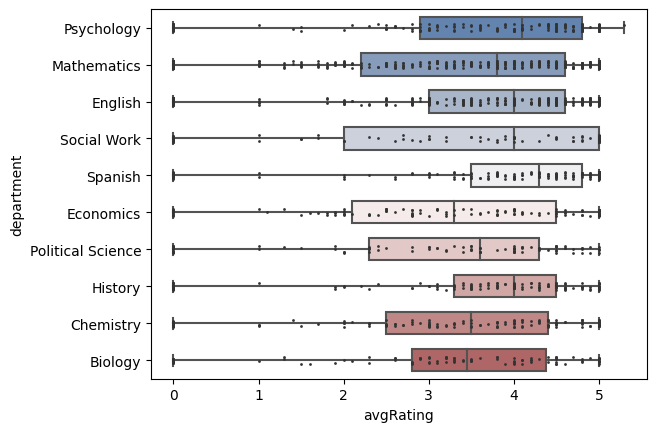

In [107]:

sns.boxplot(x='avgRating', y='department', data=depart_sorted, whis=[0, 100], width=0.6, palette='vlag')
sns.stripplot(x='avgRating', y='department', data=depart_sorted, size=2, color='0.2', linewidth=0)

In [111]:
departs.groupby('department').mean().sort_values('avgRating', ascending=False)

,avgRating
department,
Spanish,3.802516
Psychology,3.523243
History,3.509231
English,3.449451
Social Work,3.294737
Mathematics,3.252506
Biology,3.227660
Chemistry,3.161702
Economics,3.144444
